# YOLOv8 Training Tutorial

YOLOv8 is a computer vision model built by Ultralytics which support object detection, classification, key-point detection, and segmentation tasks.

In this tutorial we will fine-tunne the YOLOv8 nano model on a open source custom dataset to detect wood defects.

The dataset was made by Makar Baderko, and it is store on [Universe Roboflow](https://universe.roboflow.com/makar-baderko-kv1k2/plywood).


## Useful links
* [Dataset](https://universe.roboflow.com/makar-baderko-kv1k2/plywood/dataset/1)
* [YOLOv8 train documentation](https://docs.ultralytics.com/es/modes/train)


## Setup 🔧

In [1]:
# Check the GPU
!nvidia-smi

Mon Mar  4 00:29:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

We will use ClearML, an open source platform that automates machine learning experiment tracking.

In [2]:
%pip install ultralytics --quiet
%pip install clearml --quiet

from ultralytics import YOLO
import clearml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.7 MB/s eta 0:00:00


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Download the dataset

Download the custom dataset from Roboflow and stores it in the folder `/datasets/`

Use the following dataset parameters:

```
APIKEY = "EtT3V7SooKlsIZMuIfRK"
WORKSPACE = "makar-baderko-kv1k2"
PROJECT = "plywood"
```

In [4]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow --quiet

# Dataset parameters
APIKEY = "EtT3V7SooKlsIZMuIfRK"
WORKSPACE = "makar-baderko-kv1k2"
PROJECT = "plywood"

from roboflow import Roboflow
rf = Roboflow(api_key=APIKEY)
project = rf.workspace(WORKSPACE).project(PROJECT)
dataset = project.version(1).download("yolov8")

%cd {HOME}

/content/datasets
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 9.3 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.22, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to plywood-1 in yolov8:: 100%|██████████| 18816/18816 [00:05<00:00, 3613.68it/s]


/content


### Connect to Clear ML

Follow the steps to generate and add the key:

* Create a ClearML account in https://app.clear.ml.
* Go to [workspace-configuration](https://app.clear.ml/settings/workspace-configuration) and create new credentials
* Copy and paste the environment variables

In [5]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml

%env CLEARML_API_ACCESS_KEY=YOUR_API_KEY
%env CLEARML_API_SECRET_KEY=YOUR_SECRET_KEY

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=RQVN1YWB03KRXHMSR3DY
env: CLEARML_API_SECRET_KEY=NPPni44kzelLQDLqMTteHVTfyrbkksyHyItFgfeLgFYIl8xMvi


## 🧑 Run the training

### Fix the data.yaml file

The `data.yaml` file from the dataset need two fixes:

* Add the path to the dataset
* fix the test, train and val paths

The following script overwrite the `data.yaml` file

In [6]:
with open('datasets/plywood-1/data.yaml', 'w') as f:
    f.write("""names:
- '0'
- '1'
- '2'
- '3'
- '4'
- '5'
- '6'
- '7'
nc: 8
roboflow:
  license: CC BY 4.0
  project: plywood
  url: https://universe.roboflow.com/makar-baderko-kv1k2/plywood/dataset/1
  version: 1
  workspace: makar-baderko-kv1k2
path: /content/datasets/plywood-1/
test: test/images
train: train/images
val: valid/images
""")


### Start the training

100%|██████████| 6.23M/6.23M [00:00<00:00, 162MB/s]


Ultralytics YOLOv8.1.22 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets/plywood-1/data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=my_yolov8n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

100%|██████████| 755k/755k [00:00<00:00, 116MB/s]


Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/datasets/plywood-1/train/labels... 8685 images, 46 backgrounds, 0 corrupt: 100%|██████████| 8685/8685 [00:05<00:00, 1669.83it/s]


train: New cache created: /content/datasets/plywood-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/plywood-1/valid/labels... 540 images, 0 backgrounds, 0 corrupt: 100%|██████████| 540/540 [00:00<00:00, 869.44it/s]


val: New cache created: /content/datasets/plywood-1/valid/labels.cache
Plotting labels to runs/detect/my_yolov8n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/my_yolov8n
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.33G      1.974      3.034       1.47         18        640:  82%|████████▏ | 893/1086 [02:47<00:34,  5.52it/s]

ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


       1/10      1.37G      1.955      2.865      1.455          8        640: 100%|██████████| 1086/1086 [03:23<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.45it/s]

                   all        540       1407      0.458      0.435      0.393      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.25G      1.828      1.741       1.37         10        640: 100%|██████████| 1086/1086 [03:14<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.53it/s]

                   all        540       1407      0.446      0.495      0.435      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.26G      1.798      1.535      1.346         10        640: 100%|██████████| 1086/1086 [03:13<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:06<00:00,  5.56it/s]

                   all        540       1407      0.512       0.56      0.441      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.26G      1.769      1.426      1.333          8        640: 100%|██████████| 1086/1086 [03:12<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.73it/s]

                   all        540       1407      0.552      0.547      0.505      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.26G      1.741      1.376      1.311          8        640: 100%|██████████| 1086/1086 [03:09<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]

                   all        540       1407       0.58      0.522      0.522       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.26G      1.713      1.316      1.294          9        640: 100%|██████████| 1086/1086 [03:09<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.70it/s]

                   all        540       1407      0.472      0.578      0.541      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.26G      1.688      1.271      1.281          8        640: 100%|██████████| 1086/1086 [03:12<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:06<00:00,  5.46it/s]

                   all        540       1407      0.675      0.555      0.587      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.26G      1.662      1.229      1.264         11        640: 100%|██████████| 1086/1086 [03:13<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.06it/s]

                   all        540       1407      0.597      0.612      0.591      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.26G      1.637      1.177      1.248         11        640: 100%|██████████| 1086/1086 [03:13<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.70it/s]

                   all        540       1407      0.738      0.569      0.638      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.26G      1.616       1.14      1.233         15        640: 100%|██████████| 1086/1086 [03:13<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:06<00:00,  5.48it/s]

                   all        540       1407      0.635      0.627      0.649      0.361



10 epochs completed in 0.557 hours.
Optimizer stripped from runs/detect/my_yolov8n/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/my_yolov8n/weights/best.pt, 6.2MB

Validating runs/detect/my_yolov8n/weights/best.pt...
Ultralytics YOLOv8.1.22 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


                   all        540       1407      0.652      0.621      0.649      0.361
                     0        540         28      0.776     0.0357      0.136      0.068
                     1        540        624      0.718      0.792      0.781      0.379
                     2        540         29       0.46      0.931      0.746      0.417
                     3        540         84      0.729      0.786       0.83      0.432
                     4        540        462      0.774      0.768      0.841      0.471
                     5        540         82      0.709      0.564      0.653      0.457
                     6        540         17      0.449      0.647      0.701      0.415
                     7        540         81        0.6      0.444      0.505       0.25
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/my_yolov8n


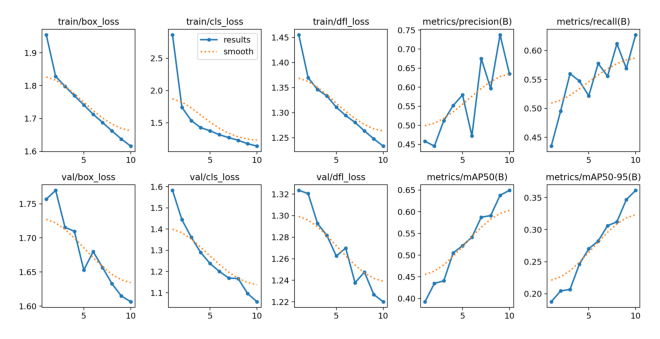

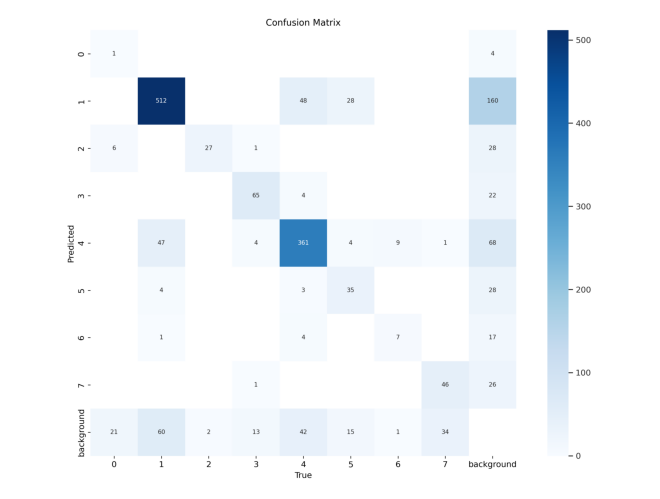

2024-03-04 01:07:07,160 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/YOLOv8/my_yolov8n.b4b85e878174436d89f43f1e38315dd8/models/best.pt


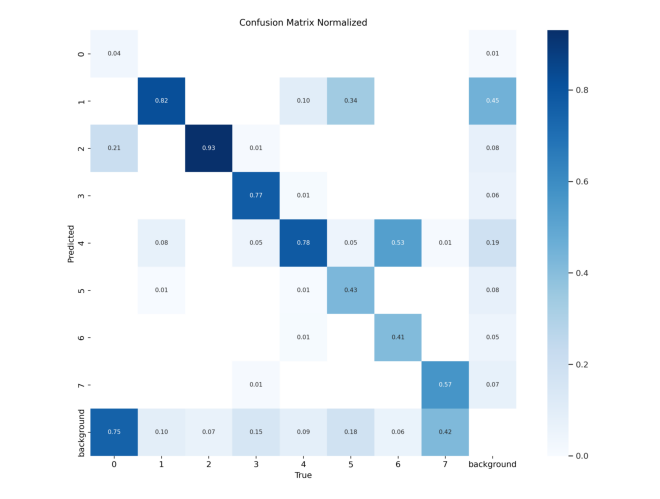

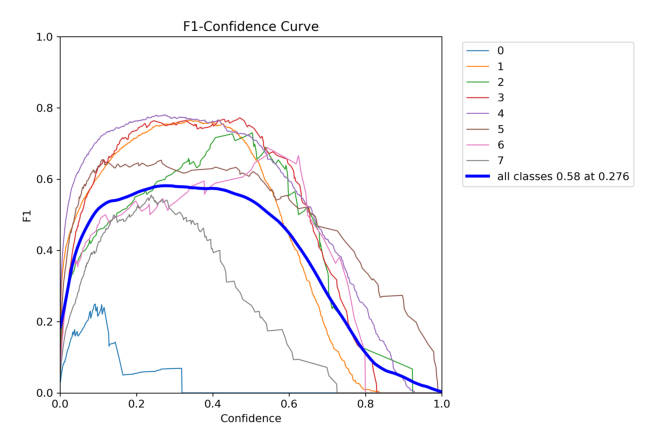

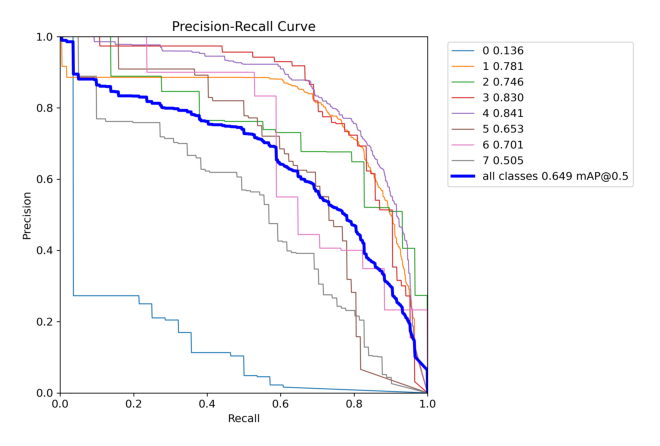

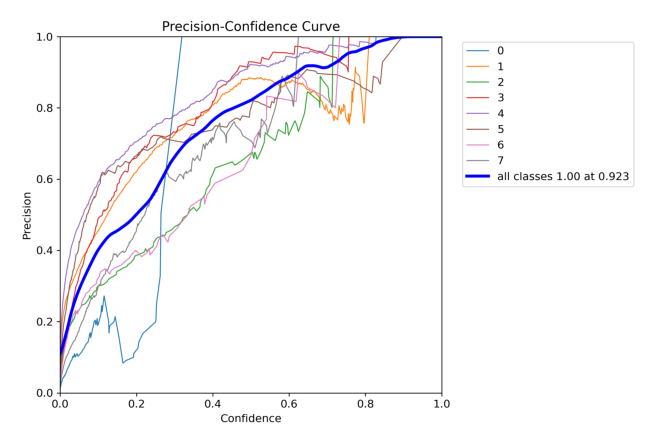

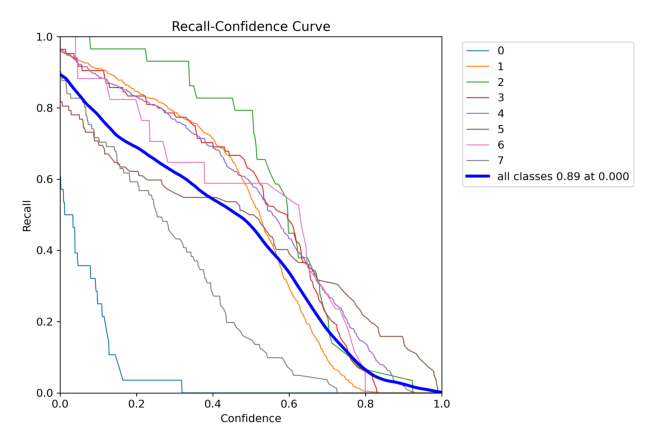

In [7]:
# Load the model.
model = YOLO('yolov8n.pt')

# Training.
results = model.train(
   data='datasets/plywood-1/data.yaml',
   imgsz=640,
   epochs=10,
   batch=8,
   name='my_yolov8n'
)


## 🕵️‍♂️ Validate the custom model

In [14]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!yolo task=detect mode=val model=./runs/detect/my_yolov8n/weights/best.pt data=./datasets/plywood-1/data.yaml


Ultralytics YOLOv8.1.22 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007208 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/datasets/plywood-1/valid/labels.cache... 540 images, 0 backgrounds, 0 corrupt: 100% 540/540 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 34/34 [00:08<00:00,  3.87it/s]
                   all        540       1407      0.639      0.629       0.65      0.361
                     0        540         28      0.676     0.0357      0.137      0.066
                     1        540        624      0.718      0.801      0.783      0.379
                     2        540         29      0.462      0.931      0.751      0.428
                     3        540         84      0.722      0.786      0.829      0.432
                     4        540        462      0.768      0.781       0.84      0.471
                     5        540         

## 🧪 Test the custom model

In [16]:
!yolo task=detect mode=predict model=./runs/detect/my_yolov8n/weights/best.pt conf=0.25 source=./datasets/plywood-1/test/images save=True


Ultralytics YOLOv8.1.22 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007208 parameters, 0 gradients, 8.1 GFLOPs

image 1/177 /content/datasets/plywood-1/test/images/100000060_jpg.rf.cda3e66062d82df1f01db2c1381ebdd5.jpg: 640x640 4 1s, 10.2ms
image 2/177 /content/datasets/plywood-1/test/images/100000074_jpg.rf.373d6313ad1596efd750c501763bbf79.jpg: 640x640 1 4, 7.4ms
image 3/177 /content/datasets/plywood-1/test/images/100100009_jpg.rf.d8266f0643a67634e7eae92961938d53.jpg: 640x640 1 1, 7.3ms
image 4/177 /content/datasets/plywood-1/test/images/100100013_jpg.rf.9fae33df8d6121bd718b89386242dcca.jpg: 640x640 1 2, 7.3ms
image 5/177 /content/datasets/plywood-1/test/images/100100040_jpg.rf.2fd9127997ba57044eeb54cc7bc18870.jpg: 640x640 1 1, 7.3ms
image 6/177 /content/datasets/plywood-1/test/images/100100071_jpg.rf.ebc6eaf59ec026680cf45c076b26654b.jpg: 640x640 3 1s, 2 7s, 7.4ms
image 7/177 /content/datasets/plywood-1/test/images/100200002_jpg.rf

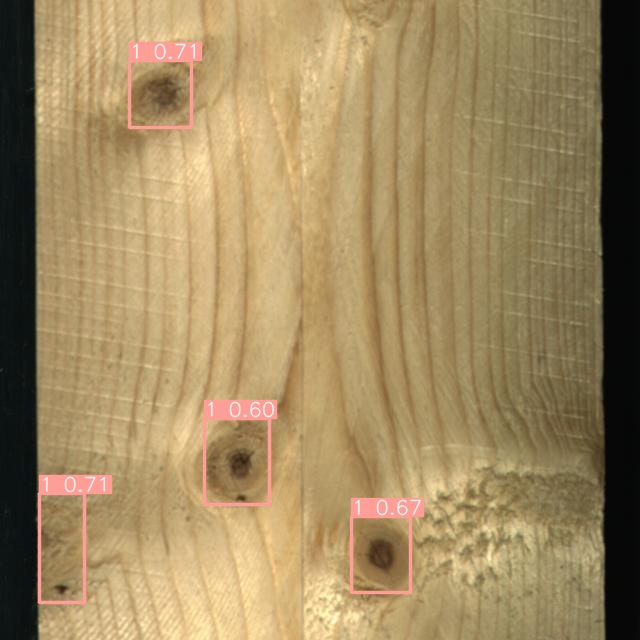

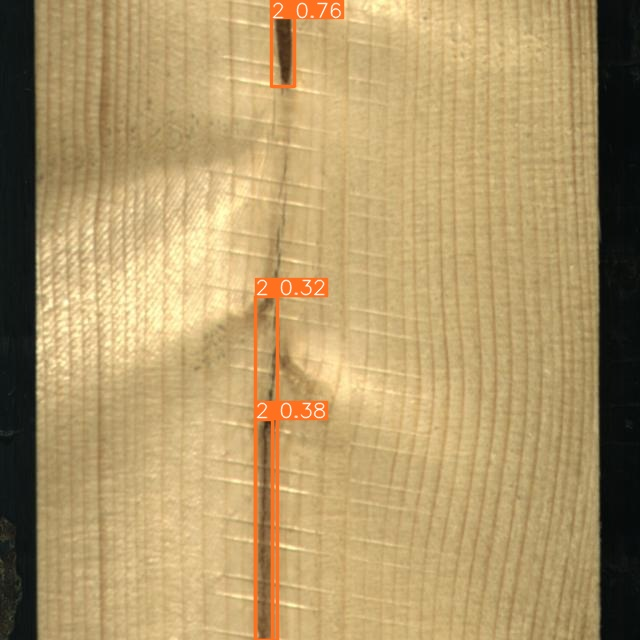

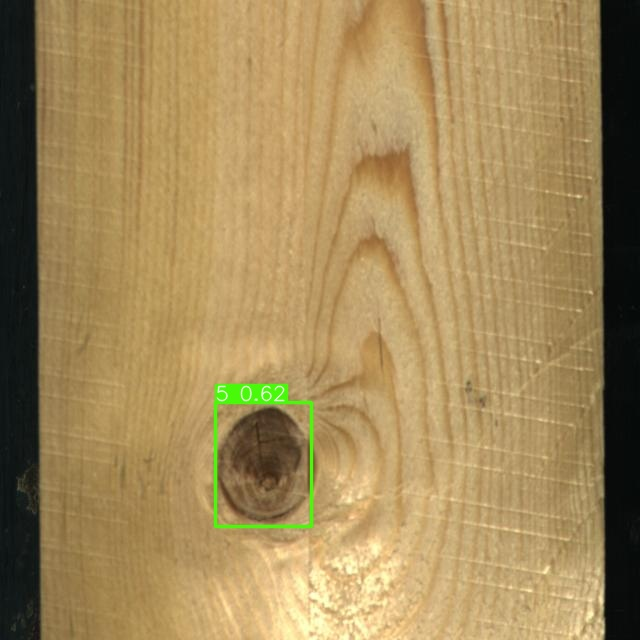

In [21]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'./runs/detect/predict/*.jpg')[:3]:
      display(Image(filename=image_path, width=640))
      print("\n")